## Simple example reconstructing the sin function


## Imports and dataset

2023-02-23 12:54:34.711314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 12:54:35.913268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-02-23 12:54:35.913502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/maxi/Repos/SGpp/lib:
2023-02-23 12:54:35.913513: W tensorflow/compiler/tf2tensorrt/utils/py_utils

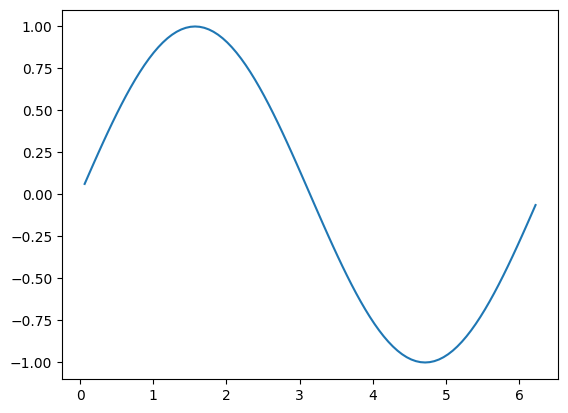

In [1]:
import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

import sklearn.metrics

def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

X = []
Y = []

num_samples = 100

for i in range(1, num_samples):
    X.append(2.0*math.pi/num_samples * float(i))
    Y.append(math.sin(2.0*math.pi/num_samples * float(i)))

plt.plot(X, Y)
plt.show()

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.reshape(-1, 1)

dataset = HPO.Dataset(X, Y)


## Hyperparameterspace & Model & Function

In [2]:
BUDGET = 50
VERBOSE = 2
CV = 2
SCORING = 'neg_mean_squared_error'

hyperparameterspace = {
    'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    #'loss': ["list", 'mean_absolute_error', 'log_cosh'],
    'epochs': ["interval-int", 1, 400]
}

##################### Model for grid and random search #####################

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_shape=(1,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation=None))
    # Compile model
    #model.compile(loss=loss,
    #              optimizer='adam', metrics=['mean_squared_error'])
    return model

##################### Blackbox function for bayesian optimization #####################

hyperparameterspace_special = {
    'loss': ['binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    'epochs': [1, 400]
}

def blackboxfunction(params):
    index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
    loss = hyperparameterspace_special["loss"][index]
    
    epochs = int(params[1])

    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        model.add(Dense(10, input_shape=(1,), activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(1, activation=None))
        # Compile model
        model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
        return model

    model = KerasRegressor(model=create_model, verbose=0)

    scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

    return -scores.mean()
    # model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

    # Y_predicted = model.predict(dataset.get_X_test())

    # return -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
    

##################### Function for sparse grid search #####################

class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(2)


    def eval(self, x):
        index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        epochs = int(from_standard(1, 400, x[1]))
        
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(10, input_shape=(1,), activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(1, activation=None))
            # Compile model
            model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

        return -scores.mean()

        # model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

        # Y_predicted = model.predict(dataset.get_X_test())

        # return sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)

## Grid search

In [6]:
print(sklearn.metrics.get_scorer_names())

model = KerasRegressor(model=create_model, verbose=0)

optimization = HPO.Optimization(dataset, model, hyperparameterspace, type="grid_search", cv=CV, budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()

print("Best result:")
print(-result.best_score_)
print("Corresponding parameters:")
print(result.best_params_)

Y_predicted = result.predict(torch.Tensor(X).reshape(-1, 1))

plt.plot(X,Y_predicted)
plt.show()

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

## Random search

/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 70 is smaller than n_iter=200. Running 70 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV] END ................epochs=15, loss=binary_crossentropy; total time=   0.7s
[CV] END ................epochs=15, loss=binary_crossentropy; total time=   0.7s
[CV] END ................epochs=15, loss=binary_crossentropy; total time=   0.7s
[CV] END ................epochs=15, loss=binary_crossentropy; total time=   0.7s
[CV] END ................epochs=15, loss=binary_crossentropy; total time=   0.7s
[CV] END ...........epochs=15, loss=categorical_crossentropy; total time=   1.3s
[CV] END ...........epochs=15, loss=categorical_crossentropy; total time=   0.8s
[CV] END ...........epochs=15, loss=categorical_crossentropy; total time=   0.8s
[CV] END ...........epochs=15, loss=categorical_crossentropy; total time=   0.8s
[CV] END ...........epochs=15, loss=categorical_crossentropy; total time=   0.8s
[CV] END ................epochs=15, loss=binary_crossentropy; total time=   0.8s
[CV] END ................epochs=15, loss=binary

/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/maxi/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/home/maxi/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/maxi/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py", line 196, in mean_absolute_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/home/maxi/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py", line 102, in _

[CV] END ..........epochs=328, loss=categorical_crossentropy; total time=   2.0s
[CV] END ..........epochs=328, loss=categorical_crossentropy; total time=   2.0s
[CV] END ...............epochs=328, loss=binary_crossentropy; total time=   2.1s
[CV] END ...............epochs=328, loss=binary_crossentropy; total time=   2.0s
[CV] END ...............epochs=328, loss=binary_crossentropy; total time=   2.0s
[CV] END ...............epochs=328, loss=binary_crossentropy; total time=   2.1s
[CV] END ...............epochs=328, loss=binary_crossentropy; total time=   2.0s
[CV] END ................epochs=328, loss=mean_squared_error; total time=   2.6s
[CV] END ................epochs=328, loss=mean_squared_error; total time=   2.1s
[CV] END ................epochs=328, loss=mean_squared_error; total time=   2.1s
[CV] END ................epochs=328, loss=mean_squared_error; total time=   2.0s
[CV] END ................epochs=328, loss=mean_squared_error; total time=   2.0s
[CV] END ...............epoc

/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-0.66055366 -0.9010191  -0.64054689 -0.61395252 -0.66748863 -0.51787711
 -0.61747947 -0.51190042 -0.45250576 -0.41672029 -0.56577861 -0.7127982
 -0.44776787 -0.45860815 -0.41731037 -0.6282639  -0.71674936 -0.56904586
 -0.44383366 -0.50312622 -0.55223326 -0.52303639 -0.53275477 -0.41873716
 -0.35860005 -0.63915741 -0.61052481 -0.56449754 -0.3549826  -0.33944885
 -0.55382822 -0.56537724 -0.65026199 -0.33995418 -0.3872717  -0.38688906
 -0.56955016 -0.61087431 -0.40297468 -0.31437966 -0.33357549 -0.8001599
 -0.54157066 -0.35044969 -0.38112758 -0.45651243 -0.58746053 -0.61224135
 -0.30936674 -0.38763072 -0.4822272  -0.60649493 -0.45944074 -0.33665842
 -0.29925212 -0.61560245         nan -0.44904238 -0.3313667  -0.32749667
 -0.32072794 -0.68042618 -0.36563993 -0.34889663 -0.33686089 -0.56318125
 -0.70637742 -0.40000068 -0.30088514 -0.3256861 ]
  

Best result:
-0.2992521248757839
Corresponding parameters:
{'loss': 'mean_absolute_error', 'epochs': 300}


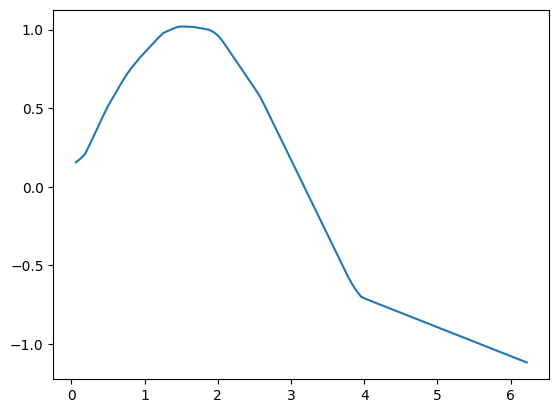

In [ ]:
model = KerasRegressor(model=create_model, loss='binary_crossentropy', verbose=0)
optimization = HPO.Optimization(dataset, model, hyperparameterspace, type="random_search", cv=CV, budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()
print("Best result:")
print(-result.best_score_)
print("Corresponding parameters:")
print(result.best_params_)

Y_predicted = result.predict(torch.Tensor(X).reshape(-1, 1))

plt.plot(X,Y_predicted)
plt.show()

## Bayesian Optimization 

https://thuijskens.github.io/2016/12/29/bayesian-optimisation/ 

Progress: [####################] 100.0%
Current time per iteration: 3.3999525790004554
Approx. time remaining: 0.0
Best MSE:
-1.9263645448684124
With Hyperparameters: 
loss: categorical_crossentropy
epochs: 380.00140158632985
[array([2.85063805e-01, 3.80001402e+02])]


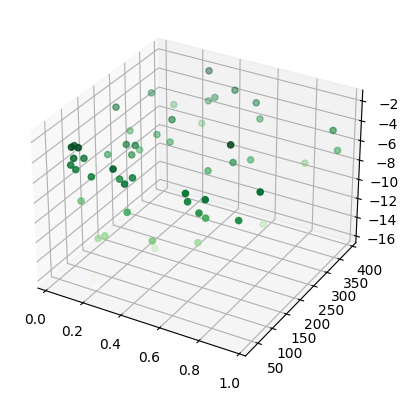

In [3]:
optimization = HPO.Optimization(dataset, blackboxfunction, hyperparameterspace, type="bayesian", budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()

fig = plt.figure()
ax = plt.axes(projection='3d')

x = [result[0][i][0] for i in range(len(result[0]))]
y = [result[0][i][1] for i in range(len(result[0]))]

ax.scatter3D(x, y, result[1], c=result[1], cmap='Greens')

index_best = 0
for i in range(len(result[1])):
    if result[1][i] == max(result[1]):
        index_best = i

best_score = result[1][index_best]
best_params = result[0][index_best]


print("Best MSE:")
print(best_score)
print("With Hyperparameters: ")
i = 0
for key in hyperparameterspace.keys():
    if hyperparameterspace[key][0] == "list":
        index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
        print(key + ": " + str(hyperparameterspace_special[key][index]))
    else:
        print(key + ": " + str(best_params[i]))
    i += 1


print([result[0][i] for i in range(len(result[0])) if result[1][i] == max(result[1])])
#print(result)

## Sparse grid search

Adaptive grid generation (Ritter-Novak)...


2023-02-16 15:04:34.641603: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-16 15:04:34.641633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maxi-XPS-15-9560): /proc/driver/nvidia/version does not exist
2023-02-16 15:04:34.642625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done in 628736ms.
Solving linear system (automatic method)...
Done in 7ms.

Optimal hyperparameters so far:
loss: mean_squared_error
epochs: 287.78125
Resulting loss:
0.0002759712572140416
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
loss: mean_squared_error
epochs: 399.9998871729489
Resulting loss (Optimal value from optimization):
-2.4937888204464413
Resulting loss (Optimal point evaluated):
0.010834456182044833


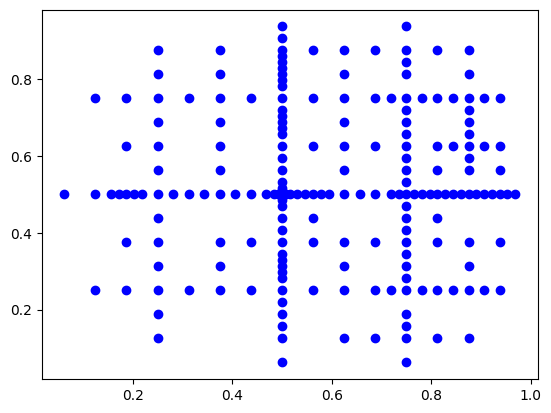

In [ ]:
f = ExampleFunction()

optimization = HPO.Optimization(dataset, f, hyperparameterspace, type="sparse", budget=BUDGET, verbosity=VERBOSE)
result = optimization.fit()
